In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

# model itself
from keras.models import Sequential
from keras.layers import LSTM, Dropout
from keras.layers import Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error
#from keras.losses import mean_absolute_percentage_error
from keras import backend as K

Using TensorFlow backend.


In [0]:
df = pd.read_csv('pvdaq_2012_2014_hourly.csv', header=0, infer_datetime_format=True, parse_dates=['Date-Time'], index_col=['Date-Time'])

In [0]:
#df = pd.read_csv('pvdaq_2012_2014_hourly.csv')

In [0]:
df.dtypes

SiteID                 float64
ac_current             float64
ac_power               float64
ac_voltage             float64
ambient_temp           float64
dc_current             float64
dc_power               float64
dc_voltage             float64
inverter_error_code    float64
inverter_temp          float64
module_temp            float64
poa_irradiance         float64
power_factor           float64
relative_humidity      float64
wind_direction         float64
wind_speed             float64
dtype: object

In [0]:
# columns to use for forecasting
cols = ['ambient_temp', 'inverter_temp', 'module_temp', 'poa_irradiance', 
        'relative_humidity', 'wind_direction', 'wind_speed']
time_indexes = [df.index.hour, df.index.month]
# we will forecast dc power output
target = ['dc_power']

In [0]:
# array stacking
def create_sequence(df, cols, target):
  seqs = []
  for col in cols:
    seq = df[col].values.reshape((len(df[col]), 1))
    seqs.append(seq)
  for index in time_indexes:
    seq = index.values.reshape((len(df[col]), 1))
    seqs.append(seq)
  seq = df[target].values.reshape((len(df[target]), 1))
  for i in range(len(seq)):
    if seq[i] < 0:
      seq[i] = 0
  seqs.append(seq)
  dataset = np.hstack((seqs))  
  return dataset

dataset = (create_sequence(df, cols, target))

In [0]:
dataset.shape

(26304, 10)

In [0]:
# single step multivariate sequence
def split_sequence(sequence, n_steps):
  X, y = list(), list()
  for i in range(len(sequence)):
    end_ix = i + n_steps
    # check if we are not beyond range
    if end_ix > len(sequence)-1:
      break
    seq_x, seq_y = sequence[i:end_ix, :], sequence[end_ix ,-1]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y)

In [0]:
X, y = split_sequence(dataset, 4)
print(X. shape, y.shape)

(26300, 4, 10) (26300,)


In [0]:
print(df.head(1), y[11])

            SiteID  ac_current  ac_power  ac_voltage  ambient_temp  \
Date-Time                                                            
2012-01-01  1277.0         0.0    -150.0       285.5      4.437502   

            dc_current  dc_power  dc_voltage  inverter_error_code  \
Date-Time                                                           
2012-01-01        -1.0    -100.0        0.25                  0.0   

            inverter_temp  module_temp  poa_irradiance  power_factor  \
Date-Time                                                              
2012-01-01           16.5     0.208335             0.0           0.0   

            relative_humidity  wind_direction  wind_speed  
Date-Time                                                  
2012-01-01             44.628        306.7035    0.565841   3400.0


In [0]:
def split_sequence_multi(sequence, n_steps, n_steps_out):
  X, y = list(), list()
  for i in range(len(sequence)):
    end_ix = i + n_steps
    out_ix = end_ix + n_steps_out
    # boundary check
    if out_ix > len(sequence):
      break
    seq_x, seq_y = sequence[i:end_ix, :], sequence[end_ix:out_ix, -1]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y)
    

In [0]:
X, y = split_sequence_multi(dataset, 12, 6)
print(X.shape, y.shape)

(26287, 12, 10) (26287, 6)


In [0]:
X[0][0], y[0]

(array([4.43750176e+00, 1.65000000e+01, 2.08334750e-01, 0.00000000e+00,
        4.46280000e+01, 3.06703500e+02, 5.65840880e-01, 0.00000000e+00,
        1.00000000e+00, 0.00000000e+00]),
 array([22600., 18175., 13400.,  3400.,   125.,     0.]))

In [0]:
X.shape, y.shape

((26287, 12, 10), (26287, 6))

In [0]:
# n_steps is amount of time steps per sample
# n_steps_out is the amount of time steps model has to forecast
n_steps, n_steps_out = 24, 6
# number of features in each timestep
n_features=X.shape[2]
X, y = split_sequence_multi(dataset, n_steps, n_steps_out)
train_X, train_y = X[:-2000,:], y[:-2000,:]
val_X, val_y = X[-2000:-1000,:], y[-2000:-1000,:]
test_X, test_y = X[-1000:,:], y[-1000:,:]

model = Sequential()
model.add(LSTM(300, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(200, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')

model.fit(train_X, train_y, batch_size=32, epochs = 20, validation_data=(val_X, val_y))
# A stateful recurrent model is one for which the internal states (memories) 
# obtained after processing a batch of samples are reused as initial states for the samples of the next batch

predictions = model.predict(test_X)



Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 24275 samples, validate on 1000 samples
Epoch 1/20
24275/24275 [==============================] - 63s 3ms/step - loss: 84946483.6408 - val_loss: 52877036.3200
Epoch 2/20
24275/24275 [==============================] - 62s 3ms/step - loss: 40613799.5172 - val_loss: 18347738.2600
Epoch 3/20
24275/24275 [==============================] - 61s 3ms/step - loss: 50096009.8241 - val_loss: 28489956.5200
Epoch 4/20
24275/24275 [==============================] - 61s 2ms/step - loss: 42475972.6098 - val_loss: 15487013.0630
Epoch 5/20
24275/24275 [==============================] - 61s 3ms/step - loss: 25854902.1579 - val_loss: 12767570.6395
Epoch 6/20
24275/24275 [==============================] - 62s 3ms/step - loss: 16942583.9158 - val_loss: 7512962.6005
Epoch 7/20
24275/24275 [==============================] - 61s 3ms/step - loss: 17319861.9293 - val_loss: 8678538.3727


In [0]:
# https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error
def sMAPE(y_true, y_pred):
    #Symmetric mean absolute percentage error
    return 100 * K.mean(K.abs(y_pred - y_true) / (K.abs(y_pred) + K.abs(y_true)), axis=-1)

In [0]:
predictions1 = model.predict(train_X)
mse = mean_squared_error(train_y, predictions1)
rmse = sqrt(mse)
mae = mean_absolute_error(train_y, predictions1)
#mape = mean_absolute_percentage_error(predictions1, test_y)
print(round(mse), round(rmse), round(mae))

14260132.0 3776 2188.0


In [0]:
mse = mean_squared_error(test_y, predictions)
rmse = sqrt(mse)
mae = mean_absolute_error(test_y, predictions)
#mape = mean_absolute_percentage_error(test_y, predictions)
#smape = sMAPE(test_y, predictions) 
print(round(mse), round(rmse), round(mae))
for i in range(len(test_y)):
  print("prediction" + str(i))
  for j in range(n_steps_out):
    print(int(abs(test_y[i][j]-predictions[i][j])), int(test_y[i][j]), int(predictions[i][j]))



13292487.0 3646 2060.0
prediction0
1099 0 1099
447 0 447
578 0 578
955 0 955
1533 100 1633
2601 5525 2923
prediction1
1248 0 1248
446 0 446
790 0 790
1699 100 1799
1723 5525 3801
9250 15575 6324
prediction2
808 0 808
516 0 516
1841 100 1941
835 5525 4689
6950 15575 8624
8407 20850 12442
prediction3
3065 0 3065
3739 100 3839
123 5525 5648
7510 15575 8064
10107 20850 10742
10797 23500 12702
prediction4
5343 100 5443
1993 5525 7518
5931 15575 9643
9122 20850 11727
10363 23500 13136
10924 24350 13425
prediction5
3197 5525 8722
4089 15575 11485
7509 20850 13340
8581 23500 14918
8973 24350 15376
7977 22625 14647
prediction6
4064 15575 11510
8142 20850 12707
10813 23500 12686
12220 24350 12129
12041 22625 10583
3836 12500 8663
prediction7
7009 20850 13840
9366 23500 14133
11444 24350 12905
11651 22625 10973
4378 12500 8121
1673 7150 5476
prediction8
12732 23500 10767
13091 24350 11258
12038 22625 10586
3114 12500 9385
261 7150 7411
3977 1450 5427
prediction9
13078 24350 11271
11628 22625 1099

In [0]:
test_y[0], test_y[6], test_y[12], test_y[18], test_y[24]
predictions[0], predictions[6], predictions[12], predictions[18], predictions[24]

(array([1099.4717 ,  447.25882,  578.987  ,  955.5521 , 1633.8153 ,
        2923.3003 ], dtype=float32),
 array([11510.026, 12707.751, 12686.263, 12129.287, 10583.93 ,  8663.394],
       dtype=float32),
 array([10552.678  ,  5938.85   ,  2024.5916 ,  -196.62265,  -995.70966,
         -573.1371 ], dtype=float32),
 array([-159.93756 ,   93.944695,  235.05133 ,   82.962395,   85.68267 ,
         692.80914 ], dtype=float32),
 array([1903.6439 ,  982.12024,  773.8321 ,  901.31616, 1593.9174 ,
        3161.8542 ], dtype=float32))

In [0]:
test_seq1 = []
pred_seq1 = []
for i in range(36):
  test_seq1 = np.concatenate((test_seq1, test_y[i*6]))
  pred_seq1 = np.concatenate((pred_seq1, predictions[i*6]))
  

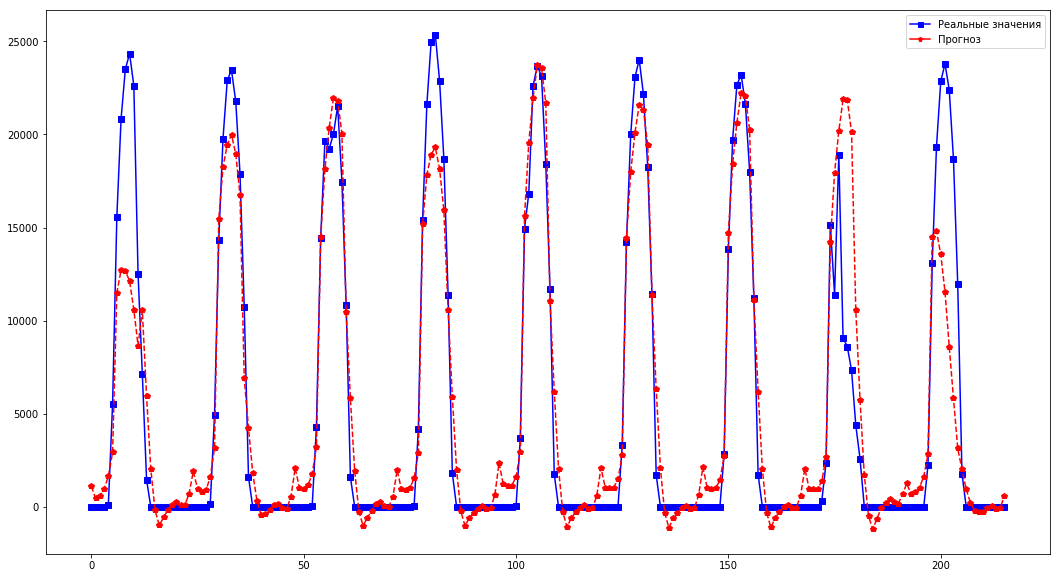

In [0]:
import matplotlib.lines as mlines

blue_line = mlines.Line2D([], [], color='blue', marker='s',
                          markersize=5, label='Реальные значения')
red_line = mlines.Line2D([], [], color='red', marker='p',
                          markersize=5, label='Прогноз')

#plt.legend(handles=[blue_line, red_line])


plt.figure(figsize=(18,10))
plt.plot(test_seq1, 'b-s')
plt.plot(pred_seq1, 'r--p')
plt.legend(handles=[blue_line, red_line])

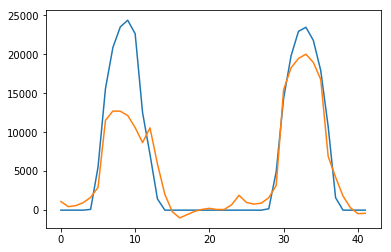

In [0]:
test_seq = np.concatenate((test_y[0], test_y[6], test_y[12], test_y[18], test_y[24], test_y[30], test_y[36]))
pred_seq = np.concatenate((predictions[0], predictions[6], predictions[12], predictions[18], predictions[24], predictions[30], predictions[36]))
plt.plot(test_seq)
plt.plot(pred_seq)

In [0]:
 from keras.utils import plot_model  
   
 ### Build, Load, and Compile your model  
   
 plot_model(model, to_file='model.png', show_layer_names=True)   